In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [4]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [5]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [6]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [8]:
data_rf = feature_engineer(data)

In [9]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [10]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [11]:
print(train_rf_x.shape) # Performed features normalization
print(train_y.shape)
print(test_rf_x.shape) # Performed features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [12]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
train_score_scaler = StandardScaler()
test_score_scaler = StandardScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [13]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)

# Feature Engineering Part_2: Create N-way interaction features

In [14]:
from sklearn.preprocessing import PolynomialFeatures

In [15]:
# The interaction features can be as 2-way interaction, 3 way or more by adjusting the polynomial degree
n_way_interactions = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [16]:
n_way_interactions_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [17]:
train_interactions = pd.DataFrame(n_way_interactions.fit_transform(train_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(train_rf_x[n_way_interactions_columns].columns))
test_interactions = pd.DataFrame(n_way_interactions.fit_transform(test_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(test_rf_x[n_way_interactions_columns].columns))

In [18]:
train_rf_x_interaction = pd.concat([train_rf_x,train_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
test_rf_x_interaction = pd.concat([test_rf_x,test_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
print(train_rf_x_interaction.shape)
print(test_rf_x_interaction.shape)

(137, 767)
(100000, 767)


# XGboost, Grid Search with Features without interaction & log_transformation_y FULL MODEL

In [19]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle

In [20]:
hyperparameters_dict = {"learning_rate": [0.1,0.2,0.3],              # range: [0,1], default = 0.3
                   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
                   # The larger gamma is, the more conservative the algorithm will be.                   
                   "gamma": [i/10.0 for i in range(1,10,2)],
                   # Maximum depth of a tree. 
                   # Increasing this value will make the model more complex and more likely to overfit
                   "max_depth": [6], 
                   # Used to control over-fitting
                   # Too high values can lead to under-fitting hence, it should be tuned using grid search
                   "min_child_weight": [1],
                   # Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced
                   "max_delta_step": [0],
                   # Denotes the fraction of observations to be randomly samples for each tree
                   # Typical values: 0.5-1
                   "subsample": [0.8],
                   # Similar to max_features in GBM, Typical values: 0.5 - 1
                   # Denotes the fraction of columns to be randomly samples for each tree.
                   "colsample_bytree": [0.8,1],
                   "colsample_bylevel": [1], # colsample_bytree will control the decision over this, default = 1
                   "colsample_bynode": [1],  # colsample_bytree will control the decision over this, default = 1
                   # L2 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_lambda": [1], # default = 1
                   # L1 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_alpha": [1],  # default = 0
                   # Control the balance of positive and negative weights, useful for unbalanced classes. 
                   # A typical value to consider: sum(negative instances) / sum(positive instances)
                   "scale_pos_weight": [1],
                   # No. of trees ensemble, too high sometimes still can cause overfitting
                   "n_estimators": [300,400], 
                   "booster": ["gbtree"],
                   "verbosity": [1],
                   "objective": ["reg:squarederror"],
                   "seed": [50]
                   }

In [102]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0.5],                       # 3rd
                          'max_depth': [4],                     # 1st to tune
                          'min_child_weight': [1],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.8],                   # 4th
                          'colsample_bytree': [0.8],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1.3],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [400],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [1]
                         }                

In [103]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [104]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 6, iid = False, scoring="neg_mean_squared_error")

In [105]:
xgboost_grid.fit(train_rf_x,log_transform_y)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0.5], 'max_depth': [4], 'min_child_weight': [1], 'max_delta_step': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [400], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'se

In [106]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(train_rf_x,log_transform_y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_R2_score)
print(best_score)
print(best_R2_score)
print(best_rf)

-0.19474596459896074
0.6857284749486563
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.5,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1.3, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.8, verbosity=1)


In [92]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [107]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[-0.19604912470677804, -0.19604912470677804, -0.19474596459896074]
[0.6953005035408982, 0.6953005035408982, 0.6857284749486563]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.5,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.8, verbosity=1), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.5,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=

In [75]:
# Another way to easy the tuning process
# to tune parameter in smaller grid, conclusion decide by cv_score
# cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}
# To update hyperparameters tuning and fix the best choices be constant
# hyperparameters2["max_depth"] = grid.best_params_['max_depth']

# Create XGBoost's DMatrix, after fine tuning the parameters

In [110]:
trainDMat = xgb.DMatrix(data = train_rf_x, label = log_transform_y)

In [111]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [112]:
num_boost_round = 3000
early_stopping_rounds = 30
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [114]:
hyperparameters_boosting ={'learning_rate': 0.01,               # 6th when boosting
                          'gamma': 0.5,                       # 3rd
                          'max_depth': 4,                     # 1st to tune
                          'min_child_weight': 1,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.8,                   # 4th
                          'colsample_bytree': 0.8,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1.3,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 400,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 1
                         }                

In [115]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 6, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-rmse:14.5502+0.0164308	test-rmse:14.549+0.0846514
[1]	train-rmse:14.4069+0.0162559	test-rmse:14.4057+0.0848303
[2]	train-rmse:14.2651+0.0160954	test-rmse:14.2638+0.0849893
[3]	train-rmse:14.1248+0.0158143	test-rmse:14.1235+0.0852804
[4]	train-rmse:13.9855+0.0157197	test-rmse:13.9843+0.0853704
[5]	train-rmse:13.8478+0.0155352	test-rmse:13.8465+0.085551
[6]	train-rmse:13.7114+0.0153749	test-rmse:13.7101+0.0857158
[7]	train-rmse:13.5762+0.0153187	test-rmse:13.575+0.0857707
[8]	train-rmse:13.4423+0.0151216	test-rmse:13.441+0.0859665
[9]	train-rmse:13.3099+0.0150033	test-rmse:13.3087+0.0860895
[10]	train-rmse:13.1787+0.0148094	test-rmse:13.1775+0.0862895
[11]	train-rmse:13.0489+0.0145146	test-rmse:13.0476+0.0865845
[12]	train-rmse:12.9205+0.0144096	test-rmse:12.9192+0.086688
[13]	train-rmse:12.7934+0.0143017	test-rmse:12.7921+0.0867997
[14]	train-rmse:12.6673+0.014259	test-rmse:12.6661+0.0868411
[15]	train-rmse:12.5426+0.0141671	test-rmse:12.5413+0.0869365
[16]	train-rmse:12.419+0

[132]	train-rmse:3.96019+0.00421845	test-rmse:3.95834+0.0968515
[133]	train-rmse:3.92176+0.00421257	test-rmse:3.9199+0.0968446
[134]	train-rmse:3.88371+0.00425624	test-rmse:3.88185+0.0968205
[135]	train-rmse:3.84598+0.00417994	test-rmse:3.8441+0.0969034
[136]	train-rmse:3.80872+0.00425476	test-rmse:3.80684+0.0968064
[137]	train-rmse:3.77194+0.00421101	test-rmse:3.77004+0.0968546
[138]	train-rmse:3.73532+0.00416453	test-rmse:3.73342+0.0969278
[139]	train-rmse:3.69899+0.00422137	test-rmse:3.69708+0.096897
[140]	train-rmse:3.66312+0.00431416	test-rmse:3.66121+0.0968464
[141]	train-rmse:3.62753+0.00432165	test-rmse:3.6256+0.0967782
[142]	train-rmse:3.59245+0.00425681	test-rmse:3.59051+0.0968531
[143]	train-rmse:3.55767+0.00429848	test-rmse:3.55573+0.0968232
[144]	train-rmse:3.5232+0.00419632	test-rmse:3.52125+0.0969106
[145]	train-rmse:3.48922+0.00418203	test-rmse:3.48726+0.0968887
[146]	train-rmse:3.45546+0.00416519	test-rmse:3.45349+0.0969197
[147]	train-rmse:3.42197+0.00421417	test-rmse

[262]	train-rmse:1.17987+0.00525867	test-rmse:1.18157+0.090543
[263]	train-rmse:1.1699+0.0052364	test-rmse:1.17193+0.090414
[264]	train-rmse:1.15989+0.00523528	test-rmse:1.16239+0.0902319
[265]	train-rmse:1.15016+0.005161	test-rmse:1.1529+0.0902618
[266]	train-rmse:1.14053+0.00510796	test-rmse:1.14331+0.0901484
[267]	train-rmse:1.13068+0.0051907	test-rmse:1.13354+0.0899578
[268]	train-rmse:1.12125+0.00514753	test-rmse:1.12457+0.0899476
[269]	train-rmse:1.1119+0.00514355	test-rmse:1.11529+0.0899371
[270]	train-rmse:1.10258+0.00503601	test-rmse:1.10629+0.0900636
[271]	train-rmse:1.09344+0.00518273	test-rmse:1.09753+0.0898418
[272]	train-rmse:1.08455+0.00522808	test-rmse:1.08879+0.0896737
[273]	train-rmse:1.07571+0.00520712	test-rmse:1.08013+0.0896801
[274]	train-rmse:1.06682+0.00526066	test-rmse:1.07135+0.0897213
[275]	train-rmse:1.0582+0.00519551	test-rmse:1.06279+0.0894381
[276]	train-rmse:1.04946+0.00510887	test-rmse:1.0541+0.0894099
[277]	train-rmse:1.04091+0.00518806	test-rmse:1.045

[388]	train-rmse:0.496388+0.00720864	test-rmse:0.546446+0.0727635
[389]	train-rmse:0.494065+0.00731201	test-rmse:0.544667+0.0726925
[390]	train-rmse:0.49185+0.00743806	test-rmse:0.54291+0.0725639
[391]	train-rmse:0.489508+0.00748442	test-rmse:0.540981+0.0724125
[392]	train-rmse:0.487345+0.00757152	test-rmse:0.539329+0.0723194
[393]	train-rmse:0.48501+0.00753627	test-rmse:0.53753+0.072324
[394]	train-rmse:0.482698+0.00758318	test-rmse:0.535858+0.0721614
[395]	train-rmse:0.480474+0.00764786	test-rmse:0.534264+0.0720013
[396]	train-rmse:0.478337+0.00787004	test-rmse:0.532668+0.0717417
[397]	train-rmse:0.476191+0.00783599	test-rmse:0.530996+0.0716678
[398]	train-rmse:0.473907+0.00780631	test-rmse:0.529268+0.0716401
[399]	train-rmse:0.471782+0.00779608	test-rmse:0.527665+0.0713562
[400]	train-rmse:0.469632+0.00794024	test-rmse:0.52604+0.0710262
[401]	train-rmse:0.467625+0.0079632	test-rmse:0.524667+0.0709558
[402]	train-rmse:0.465346+0.00794465	test-rmse:0.523197+0.0709604
[403]	train-rmse:

[514]	train-rmse:0.344006+0.00902989	test-rmse:0.449468+0.0725348
[515]	train-rmse:0.343704+0.00907422	test-rmse:0.449308+0.0726176
[516]	train-rmse:0.343379+0.00902117	test-rmse:0.449146+0.072629
[517]	train-rmse:0.342866+0.00910663	test-rmse:0.448992+0.0726491
[518]	train-rmse:0.342376+0.00907693	test-rmse:0.448776+0.0727538
[519]	train-rmse:0.342058+0.00902941	test-rmse:0.448623+0.0727468
[520]	train-rmse:0.341721+0.00913148	test-rmse:0.448434+0.0727417
[521]	train-rmse:0.341414+0.00917631	test-rmse:0.448285+0.0727894
[522]	train-rmse:0.34095+0.00908127	test-rmse:0.448+0.072843
[523]	train-rmse:0.340469+0.00916779	test-rmse:0.447861+0.0728749
[524]	train-rmse:0.340133+0.0091355	test-rmse:0.447658+0.072936
[525]	train-rmse:0.339755+0.00924604	test-rmse:0.447659+0.0730565
[526]	train-rmse:0.339423+0.00927939	test-rmse:0.44749+0.0730889
[527]	train-rmse:0.338907+0.00939867	test-rmse:0.447191+0.0730391
[528]	train-rmse:0.338455+0.00941381	test-rmse:0.447092+0.0731207
[529]	train-rmse:0.

[639]	train-rmse:0.314455+0.00919695	test-rmse:0.439188+0.0785858
[640]	train-rmse:0.314304+0.00930122	test-rmse:0.439107+0.0785393
[641]	train-rmse:0.314109+0.00927491	test-rmse:0.439071+0.0786231
[642]	train-rmse:0.313983+0.00922775	test-rmse:0.439049+0.0787166
[643]	train-rmse:0.313924+0.00927025	test-rmse:0.439051+0.0787072
[644]	train-rmse:0.313786+0.00935238	test-rmse:0.439035+0.0787246
[645]	train-rmse:0.313725+0.00940159	test-rmse:0.439003+0.07872
[646]	train-rmse:0.313704+0.0094043	test-rmse:0.438999+0.0787049
[647]	train-rmse:0.313624+0.00947486	test-rmse:0.439063+0.078757
[648]	train-rmse:0.313443+0.00962854	test-rmse:0.439061+0.078747
[649]	train-rmse:0.313356+0.00953348	test-rmse:0.439051+0.0787711
[650]	train-rmse:0.313154+0.00938117	test-rmse:0.438968+0.0789478
[651]	train-rmse:0.313048+0.00943807	test-rmse:0.438963+0.0789746
[652]	train-rmse:0.312778+0.00949512	test-rmse:0.438942+0.0791514
[653]	train-rmse:0.312657+0.0094174	test-rmse:0.438905+0.0792185
[654]	train-rmse

[764]	train-rmse:0.303466+0.00921621	test-rmse:0.436815+0.0817016
[765]	train-rmse:0.303461+0.0092167	test-rmse:0.436807+0.0817013
[766]	train-rmse:0.303459+0.00921841	test-rmse:0.43681+0.0817036
[767]	train-rmse:0.303361+0.00913917	test-rmse:0.436902+0.0815473
[768]	train-rmse:0.303356+0.00913777	test-rmse:0.43692+0.0815651
[769]	train-rmse:0.303353+0.00913823	test-rmse:0.436925+0.0815733
[770]	train-rmse:0.303349+0.00913628	test-rmse:0.436921+0.0815679
[771]	train-rmse:0.303235+0.00905645	test-rmse:0.43693+0.0815394
[772]	train-rmse:0.303232+0.00905682	test-rmse:0.436927+0.0815525
[773]	train-rmse:0.303229+0.00905538	test-rmse:0.436947+0.0815817
[774]	train-rmse:0.303151+0.00912594	test-rmse:0.436944+0.081592


# Finalise XGboost model

In [123]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

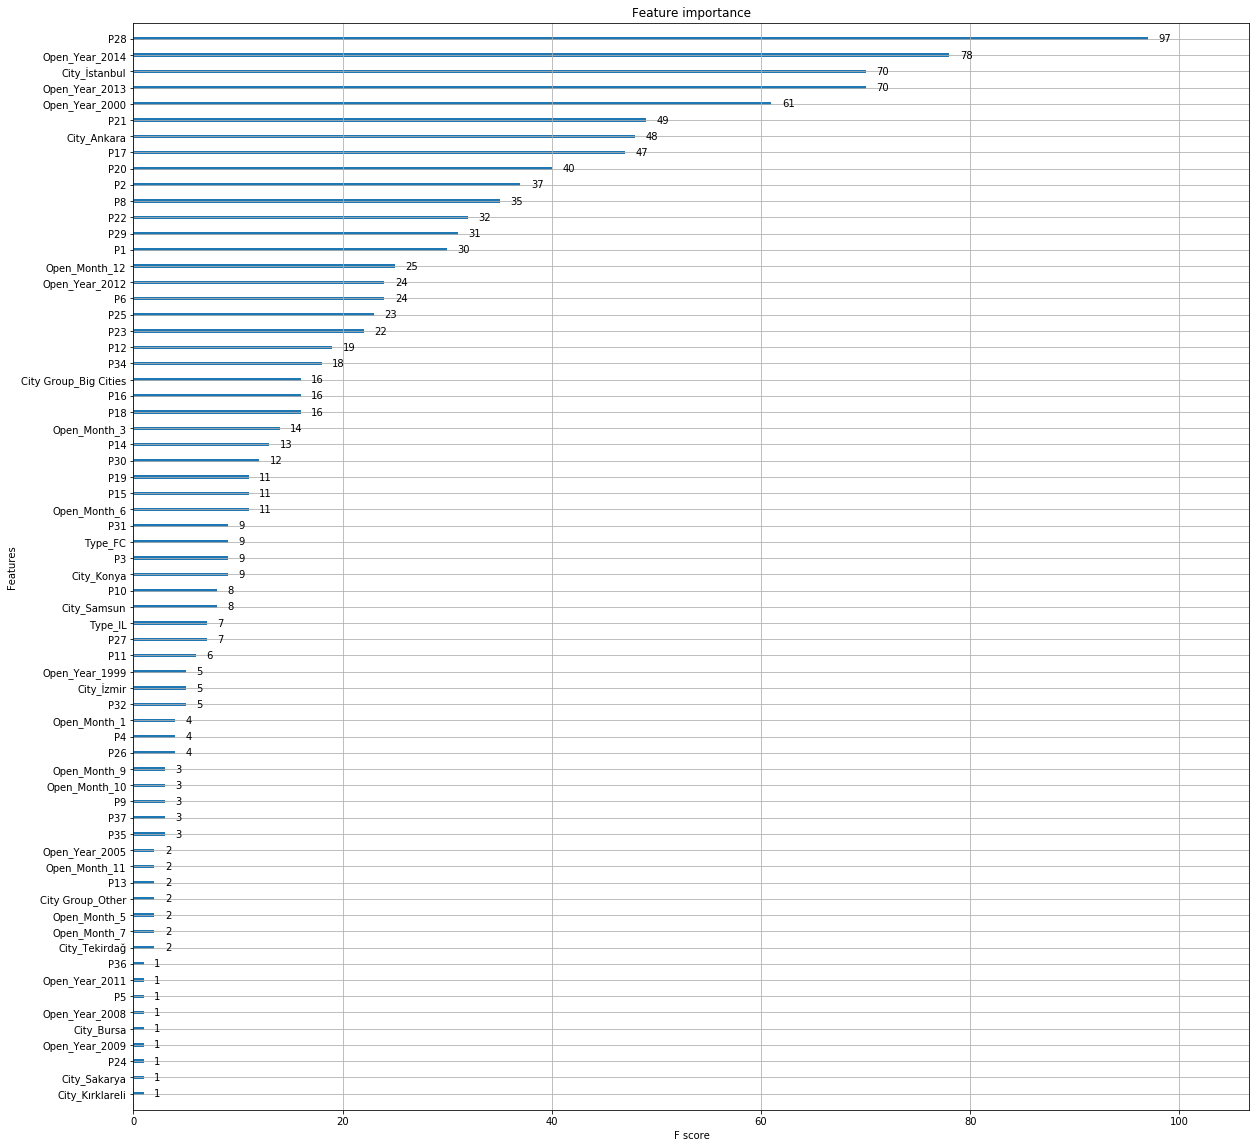

In [122]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# Prediction for Kaggle Submission

In [124]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x))
xgbFinal_submission = np.exp(xgbFinal_submission)

In [125]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_full_model_13th_trial.csv',header=True, index=False)

# Saving the final model

In [140]:
pickle.dump(xgbFinal, open("xgbFinal.pickle.dat", "wb"))

# Loading the final model

In [142]:
xgb_test = pickle.load(open("xgbFinal.pickle.dat", "rb"))

In [143]:
# Re-forecast the prediction to verify the model
xgb_test_p = xgb_test.predict(xgb.DMatrix(test_rf_x))
xgb_test_p = np.exp(xgb_test_p)

In [150]:
verify_model = (xgbFinal_submission == xgb_test_p)
verify_model.sum()

100000

# XGboost, Grid Search with 2-way interaction Features & log_transformation_y

In [191]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0.9],                       # 3rd
                          'max_depth': [8],                     # 1st to tune
                          'min_child_weight': [7],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.8],                   # 4th
                          'colsample_bytree': [0.8],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [780],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [1]
                         }                

In [192]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [193]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 6, iid = False, scoring="neg_mean_squared_error")

In [194]:
xgboost_grid.fit(train_rf_x_interaction,log_transform_y)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0.9], 'max_depth': [8], 'min_child_weight': [7], 'max_delta_step': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [1], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [780], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'seed': [1]},
       pre_dispatch='2*n_jobs', refi

In [195]:
best_cv_score = xgboost_grid.cv_results_
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(train_rf_x_interaction,log_transform_y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_R2_score)
print(best_score)
print(best_R2_score)
print(best_rf)

-0.17951258851345084
0.7015533588088118
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.9,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=7, missing=None, n_estimators=780,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.8, verbosity=1)


In [130]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [196]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[-0.20402199816154395, -0.20401817789837717, -0.18219425722869223, -0.17951258851345084, -9975290098546.92, -0.17951258851345084]
[0.9999992890798933, 0.9999993052730449, 0.7088568666940466, 0.7015533588088118, 0.9995234591082705, 0.7015533588088118]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.8, verbosity=1), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=780,
       n_jobs=1, nthread=N

In [75]:
# Another way to easy the tuning process
# to tune parameter in smaller grid, conclusion decide by cv_score
# cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}
# To update hyperparameters tuning and fix the best choices be constant
# hyperparameters2["max_depth"] = grid.best_params_['max_depth']

# Create XGBoost's DMatrix, after fine tuning the parameters

In [181]:
trainDMat = xgb.DMatrix(data = train_rf_x_interaction, label = log_transform_y)

In [182]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [183]:
num_boost_round = 6000
early_stopping_rounds = 30
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [185]:
hyperparameters_boosting={'learning_rate': 0.01,               # 6th when boosting
                          'gamma': 0.9,                       # 3rd
                          'max_depth': 8,                     # 1st to tune
                          'min_child_weight': 7,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.8,                   # 4th
                          'colsample_bytree': 0.8,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 780,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 1
                         }                

In [186]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 6, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-rmse:5.09682e+06+131549	test-rmse:5.05145e+06+674787
[1]	train-rmse:5.05579e+06+130722	test-rmse:5.0131e+06+675730
[2]	train-rmse:5.01623e+06+129955	test-rmse:4.97772e+06+675309
[3]	train-rmse:4.9784e+06+128943	test-rmse:4.94262e+06+676443
[4]	train-rmse:4.93951e+06+129116	test-rmse:4.90578e+06+678192
[5]	train-rmse:4.90137e+06+128170	test-rmse:4.86962e+06+680689
[6]	train-rmse:4.86336e+06+127575	test-rmse:4.83357e+06+682213
[7]	train-rmse:4.8254e+06+127233	test-rmse:4.79808e+06+683728
[8]	train-rmse:4.78727e+06+126659	test-rmse:4.7635e+06+685758
[9]	train-rmse:4.75032e+06+126117	test-rmse:4.7295e+06+689696
[10]	train-rmse:4.71282e+06+125708	test-rmse:4.69632e+06+689873
[11]	train-rmse:4.67667e+06+124902	test-rmse:4.66332e+06+692723
[12]	train-rmse:4.64155e+06+124966	test-rmse:4.63023e+06+693756
[13]	train-rmse:4.60687e+06+124153	test-rmse:4.59793e+06+696536
[14]	train-rmse:4.5706e+06+123336	test-rmse:4.56407e+06+699342
[15]	train-rmse:4.53592e+06+123449	test-rmse:4.52948e+06

[129]	train-rmse:2.2348e+06+125521	test-rmse:2.63358e+06+740359
[130]	train-rmse:2.22536e+06+125429	test-rmse:2.62837e+06+740832
[131]	train-rmse:2.21534e+06+125823	test-rmse:2.62127e+06+741441
[132]	train-rmse:2.20491e+06+126257	test-rmse:2.61501e+06+741541
[133]	train-rmse:2.19598e+06+126312	test-rmse:2.61006e+06+740637
[134]	train-rmse:2.18649e+06+126843	test-rmse:2.6046e+06+739491
[135]	train-rmse:2.17737e+06+127021	test-rmse:2.59852e+06+739673
[136]	train-rmse:2.16751e+06+127744	test-rmse:2.59378e+06+740302
[137]	train-rmse:2.15816e+06+127871	test-rmse:2.58957e+06+740186
[138]	train-rmse:2.14846e+06+127856	test-rmse:2.58313e+06+741473
[139]	train-rmse:2.13848e+06+128315	test-rmse:2.57806e+06+741353
[140]	train-rmse:2.129e+06+128436	test-rmse:2.57389e+06+740299
[141]	train-rmse:2.11969e+06+128401	test-rmse:2.56896e+06+739182
[142]	train-rmse:2.11048e+06+128781	test-rmse:2.56365e+06+738602
[143]	train-rmse:2.10086e+06+129307	test-rmse:2.55797e+06+736799
[144]	train-rmse:2.09172e+06+

[256]	train-rmse:1.50814e+06+148576	test-rmse:2.35192e+06+671022
[257]	train-rmse:1.50531e+06+148561	test-rmse:2.35083e+06+671629
[258]	train-rmse:1.50237e+06+148775	test-rmse:2.34943e+06+671500
[259]	train-rmse:1.49955e+06+149287	test-rmse:2.34803e+06+670870
[260]	train-rmse:1.49666e+06+149502	test-rmse:2.34698e+06+671561
[261]	train-rmse:1.49396e+06+149726	test-rmse:2.34538e+06+672273
[262]	train-rmse:1.4913e+06+149887	test-rmse:2.34607e+06+671749
[263]	train-rmse:1.48827e+06+150113	test-rmse:2.34655e+06+670872
[264]	train-rmse:1.48531e+06+150207	test-rmse:2.34673e+06+669490
[265]	train-rmse:1.48223e+06+150224	test-rmse:2.34551e+06+669451
[266]	train-rmse:1.47974e+06+150237	test-rmse:2.3449e+06+668833
[267]	train-rmse:1.47643e+06+150020	test-rmse:2.34531e+06+669277
[268]	train-rmse:1.47396e+06+149756	test-rmse:2.34617e+06+668071
[269]	train-rmse:1.47099e+06+149810	test-rmse:2.34668e+06+667570
[270]	train-rmse:1.46819e+06+149368	test-rmse:2.34731e+06+667692
[271]	train-rmse:1.46566e+0

# Finalise XGboost model

In [187]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

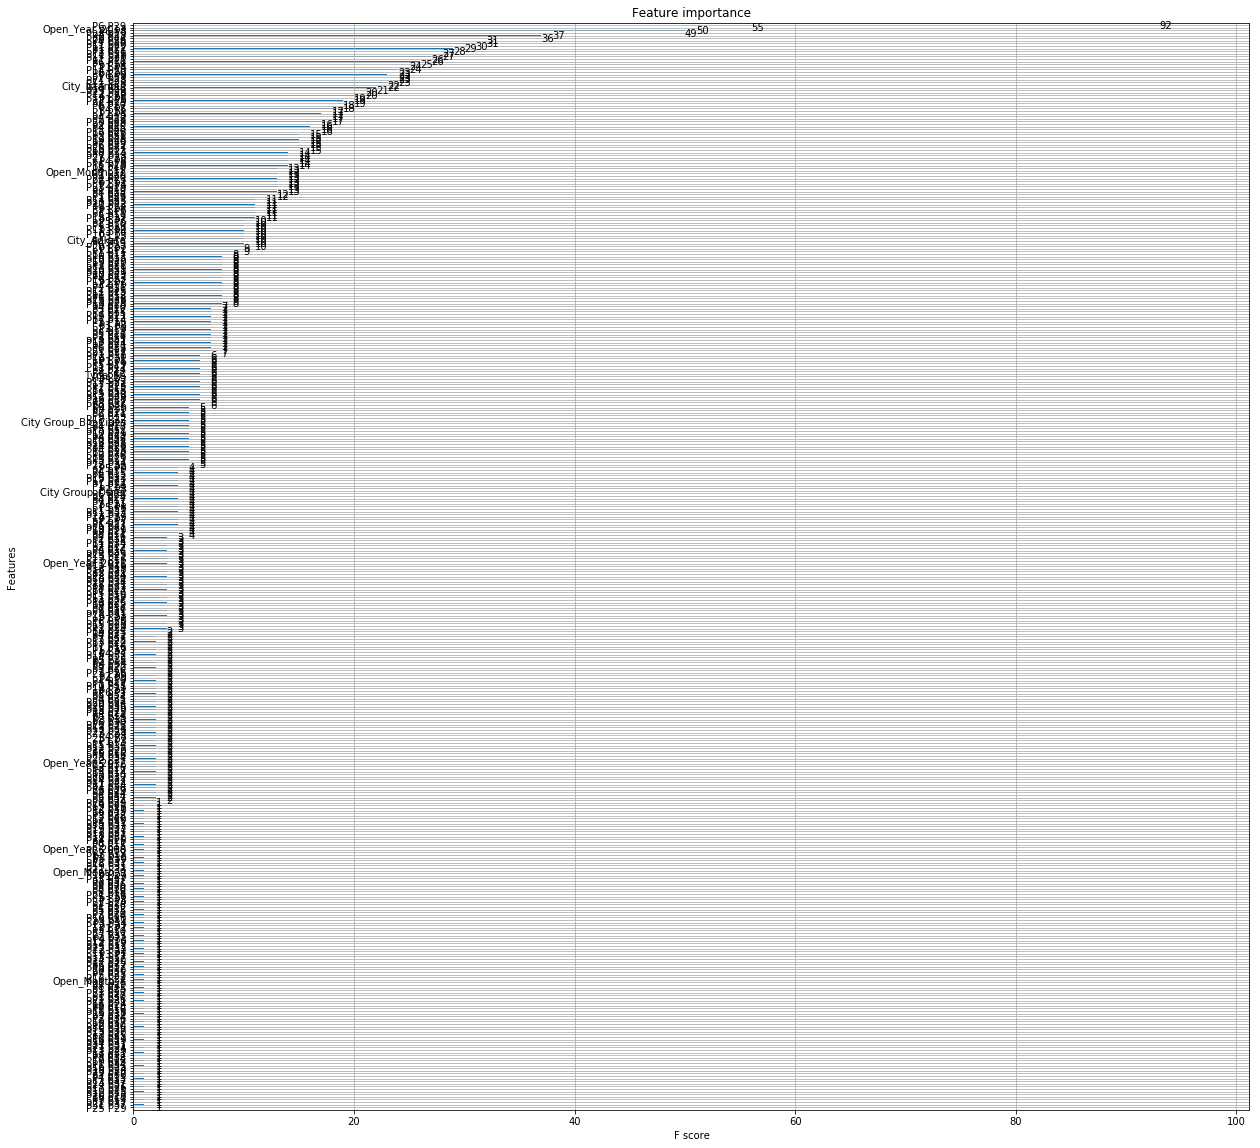

In [188]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# Prediction for Kaggle Submission

In [173]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x_interaction))
xgbFinal_submission = np.exp(xgbFinal_submission)

In [189]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x_interaction))

In [200]:
xgbFinal_submission = best_rf.predict(test_rf_x_interaction)
xgbFinal_submission = np.exp(xgbFinal_submission)

In [201]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_full_model_interaction_without_boosting_16th_trial.csv',header=True, index=False)